<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/MAFSwinTinyFocalLossHAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Swin-Tiny Modality Attention Fusion with Focal Loss Trained on Ham 10000**

To test the valididaty of the results from the proposed method, the Swin-Tiny MAF model will be trained on the Ham 10000 dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import Swinv2Model
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# **Importing Ham 10000**

In [ ]:
! pip install kaggle

In [ ]:
# Remove the file if it exists and is not a directory
if os.path.exists("/root/.kaggle") and not os.path.isdir("/root/.kaggle"):
    os.remove("/root/.kaggle")

# Create the directory
os.makedirs("/root/.kaggle", exist_ok=True)

In [ ]:
!cp /content/drive/MyDrive/Final\ Year\ Project/Data/Kaggle\ API/kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


# **Defining Dataset, Classes, Weights, and Focal Loss**

In [ ]:
# Dataset
class HAMDataset(Dataset):
    def __init__(self, dataframe, img_dir, augment=True):
        self.df = dataframe.copy()
        self.img_dir = img_dir
        self.augment = augment

        # Rename for consistency
        if 'image_id' in self.df.columns:
            self.df.rename(columns={'image_id': 'img_id', 'dx': 'diagnostic'}, inplace=True)

        # Label encoding (if not already done)
        if 'label_encoded' not in self.df.columns:
            label_dict = {label: idx for idx, label in enumerate(sorted(self.df['diagnostic'].unique()))}
            self.df['label_encoded'] = self.df['diagnostic'].map(label_dict)
            self.label_dict = label_dict
        else:
            self.label_dict = {label: idx for idx, label in enumerate(sorted(self.df['diagnostic'].unique()))}
        if 'sex' in self.df.columns:
            self.df['sex'] = self.df['sex'].map({'male': 0, 'female': 1}).fillna(0)
        if 'localization' in self.df.columns:
            self.df['localization'] = self.df['localization'].astype('category').cat.codes
        if 'age' in self.df.columns:
            self.df['age'] = self.df['age'].fillna(0)

        # Metadata columns used for the MLP
        self.metadata_cols = ['age', 'sex', 'localization']

        # Final image transforms
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.base_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        print("Using metadata columns:", self.metadata_cols)
        print("Label dictionary:", self.label_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 100
        while attempts < max_attempts:
            try:
                row = self.df.iloc[idx]
                img_path = os.path.join(self.img_dir, row['img_id'] + ".jpg") if not row['img_id'].endswith(".jpg") else os.path.join(self.img_dir, row['img_id'])
                image = Image.open(img_path).convert("RGB")
                image = self.transform(image) if self.augment else self.base_transform(image)

                metadata = torch.tensor(row[self.metadata_cols].astype(float).values, dtype=torch.float32)
                label = row['label_encoded']
                return image, metadata, label

            except (FileNotFoundError, UnidentifiedImageError):
                attempts += 1
                idx = random.randint(0, len(self.df) - 1)

        raise Exception(f"Failed to load image after {max_attempts} attempts.")


In [ ]:
# Balanced sampling
def make_weights_for_balanced_classes(dataset):
    class_counts = dataset.df['label_encoded'].value_counts()
    num_samples = len(dataset)
    class_weights = {i: num_samples / class_counts[i] for i in range(len(class_counts))}
    weights = [class_weights[label] for label in dataset.df['label_encoded']]
    return weights

In [ ]:
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super(ModalityAttentionFusion, self).__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)

        # Split weights
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)

        # Weighted fusion
        fused = img_alpha * img_feat + meta_alpha * meta_feat
        return fused

In [ ]:
# Multi-modal model
class MultiModalSwinClassifier(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super(MultiModalSwinClassifier, self).__init__()

        self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

        self.image_fc = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        self.fusion = ModalityAttentionFusion(128, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, image, metadata):
        image_features = self.image_model(image).pooler_output
        image_features = self.image_fc(image_features)

        metadata_features = self.metadata_fc(metadata)
        fused = self.fusion(image_features, metadata_features)

        return self.classifier(fused)

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, metadata, labels in loop:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total


In [ ]:
# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    loop = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, metadata, labels in loop:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_preds, all_labels

In [ ]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# **Defining Model**

In [ ]:
# Load metadata
ham_df = pd.read_csv("/content/HAM10000_metadata.csv")

# Renamed columns to match PAD-UFES dataset
ham_df = ham_df.rename(columns={
    "image_id": "img_id",
    "dx": "diagnostic",
    "lesion_id": "lesion_id",
    "age": "age",
    "sex": "sex",
    "localization": "localization"
})

# Encode labels
ham_df['label_encoded'] = LabelEncoder().fit_transform(ham_df['diagnostic'])

# Convert categorical metadata to numeric
ham_df['sex'] = ham_df['sex'].map({'male': 0, 'female': 1}).fillna(0)
ham_df['localization'] = ham_df['localization'].astype('category').cat.codes

# Fill missing values
ham_df[['age']] = ham_df[['age']].fillna(0)

# Save for reproducibility
ham_df.to_csv("/content/ham10000_preprocessed.csv", index=False)

In [ ]:
!mkdir /content/HAM10000_all
!cp /content/HAM10000_images_part_1/*.jpg /content/HAM10000_all/
!cp /content/HAM10000_images_part_2/*.jpg /content/HAM10000_all/

In [ ]:
train_csv = "/content/ham10000_preprocessed.csv"
img_dir = "/content/HAM10000_all"

In [ ]:
train_df, test_df = train_test_split(ham_df, test_size=0.2, stratify=ham_df['label_encoded'], random_state=42)

In [ ]:
metadata_cols = ['age', 'sex', 'localization']

In [ ]:
# StandardScaler
scaler = StandardScaler()
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Datasets and Loaders
train_ds = HAMDataset(train_df, img_dir)
test_ds = HAMDataset(test_df, img_dir, augment=False)

Using metadata columns: ['age', 'sex', 'localization']
Label dictionary: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Using metadata columns: ['age', 'sex', 'localization']
Label dictionary: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
weights = make_weights_for_balanced_classes(train_ds)
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
train_loader = DataLoader(train_ds, batch_size=12, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=12)

In [ ]:
# Model
model = MultiModalSwinClassifier(
    num_classes=len(train_ds.label_dict),
    metadata_dim=len(train_ds.metadata_cols)
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [ ]:
print("Label Dictionary:", train_ds.label_dict)

Label Dictionary: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
alpha = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0]).to(device)

In [ ]:
# Training setup
criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

epochs = 25
patience = 10
best_val_acc = 0.0
epochs_no_improve = 0

# Track metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

lrs = []

# **Training Model**

In [ ]:
save_path = "/content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth"

In [ ]:
# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Training:   0%|          | 0/668 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Epoch 01 | Train Loss: 0.6543 | Val Loss: 0.3620 | Train Acc: 0.6459 | Val Acc: 0.6800
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 02 | Train Loss: 0.2861 | Val Loss: 0.3144 | Train Acc: 0.8100 | Val Acc: 0.7449
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 03 | Train Loss: 0.1996 | Val Loss: 0.2472 | Train Acc: 0.8480 | Val Acc: 0.7968
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 04 | Train Loss: 0.1923 | Val Loss: 0.3567 | Train Acc: 0.8528 | Val Acc: 0.7089


Epoch 05 | Train Loss: 0.1452 | Val Loss: 0.3444 | Train Acc: 0.8787 | Val Acc: 0.6910


Epoch 06 | Train Loss: 0.1154 | Val Loss: 0.2119 | Train Acc: 0.9008 | Val Acc: 0.8263
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 07 | Train Loss: 0.1233 | Val Loss: 0.2003 | Train Acc: 0.8970 | Val Acc: 0.8313
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 08 | Train Loss: 0.1178 | Val Loss: 0.2518 | Train Acc: 0.9043 | Val Acc: 0.8303


Epoch 09 | Train Loss: 0.1169 | Val Loss: 0.2503 | Train Acc: 0.9015 | Val Acc: 0.7913


Epoch 10 | Train Loss: 0.0921 | Val Loss: 0.2833 | Train Acc: 0.9179 | Val Acc: 0.7823


Epoch 11 | Train Loss: 0.0543 | Val Loss: 0.2456 | Train Acc: 0.9438 | Val Acc: 0.7993


Epoch 12 | Train Loss: 0.0374 | Val Loss: 0.2306 | Train Acc: 0.9598 | Val Acc: 0.8098


Epoch 13 | Train Loss: 0.0432 | Val Loss: 0.1893 | Train Acc: 0.9563 | Val Acc: 0.8532
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 14 | Train Loss: 0.0369 | Val Loss: 0.1786 | Train Acc: 0.9601 | Val Acc: 0.8657
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 15 | Train Loss: 0.0415 | Val Loss: 0.1548 | Train Acc: 0.9608 | Val Acc: 0.8932
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 16 | Train Loss: 0.0396 | Val Loss: 0.1923 | Train Acc: 0.9591 | Val Acc: 0.8512


Epoch 17 | Train Loss: 0.0387 | Val Loss: 0.2102 | Train Acc: 0.9603 | Val Acc: 0.8432


Epoch 18 | Train Loss: 0.0399 | Val Loss: 0.1930 | Train Acc: 0.9599 | Val Acc: 0.8432


Epoch 19 | Train Loss: 0.0239 | Val Loss: 0.1687 | Train Acc: 0.9733 | Val Acc: 0.8907


Epoch 20 | Train Loss: 0.0154 | Val Loss: 0.1729 | Train Acc: 0.9812 | Val Acc: 0.8992
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 21 | Train Loss: 0.0187 | Val Loss: 0.1944 | Train Acc: 0.9794 | Val Acc: 0.8892


Epoch 22 | Train Loss: 0.0185 | Val Loss: 0.1735 | Train Acc: 0.9813 | Val Acc: 0.9066
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 23 | Train Loss: 0.0177 | Val Loss: 0.1722 | Train Acc: 0.9798 | Val Acc: 0.9041


Epoch 24 | Train Loss: 0.0136 | Val Loss: 0.1865 | Train Acc: 0.9846 | Val Acc: 0.9076
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/ham10000_best_model.pth


Epoch 25 | Train Loss: 0.0156 | Val Loss: 0.1699 | Train Acc: 0.9824 | Val Acc: 0.9011


# **Evaluation**

In [ ]:
class_names = [label for label, idx in sorted(train_ds.label_dict.items(), key=lambda x: x[1])]

In [ ]:
# Load best model
model.load_state_dict(torch.load(save_path))
model.to(device)

val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)


Classification Report:
               precision    recall  f1-score   support

       akiec       0.85      0.86      0.85        65
         bcc       0.90      0.92      0.91       103
         bkl       0.79      0.83      0.81       220
          df       0.96      1.00      0.98        23
         mel       0.75      0.74      0.75       223
          nv       0.95      0.95      0.95      1341
        vasc       1.00      0.89      0.94        28

    accuracy                           0.91      2003
   macro avg       0.89      0.89      0.88      2003
weighted avg       0.91      0.91      0.91      2003



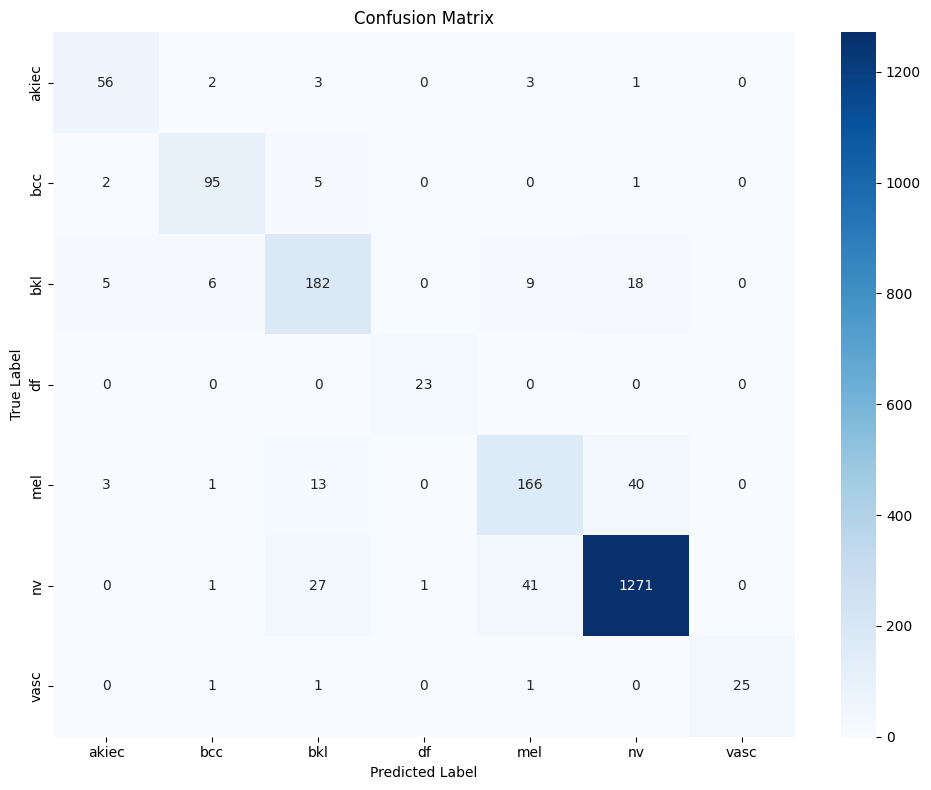

In [ ]:
val_preds = [int(p) for p in val_preds]
val_labels = [int(l) for l in val_labels]

# Classification report
report = classification_report(val_labels, val_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()